# Bank Marketing Campaign Analysis
## Predicting Term Deposit Subscription

**Author:** Zeinulla Kurmangaliyev
**Dataset:** UCI Bank Marketing Dataset  
**Source:** https://archive.ics.uci.edu/dataset/222/bank+marketing

## 1. Introduction and Objective

### Project Overview
This project analyzes a Portuguese bank's marketing campaign dataset with the goal of predicting whether a customer will subscribe to a term deposit (variable 'y').

**Business Context:**
The bank conducted direct marketing campaigns via phone calls. The dataset contains information about:
- Client demographics (age, job, marital status, education)
- Financial information (balance, loans)
- Campaign details (contact type, number of contacts, timing)
- Previous campaign outcomes
- Other categorical features

**Objective:**
Develop a machine learning model to predict the target variable 'y' (whether the client subscribes to a term deposit) to help the bank optimize future marketing campaigns by identifying promising customers.

## 2. Exploratory Data Analysis (EDA)

### Initial Data Inspection
Let's examine the structure and basic statistics of our dataset to understand what we're working with.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [23]:
df = pd.read_csv(r'bank-full.csv', sep=';')

In [24]:
pd.set_option('display.max_column', 20)
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [25]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Feature Renaming for Clarity
To improve code readability, I'll rename campaign-related features with prefixes:
- 'lc_' for "last campaign" features
- 'pc_' for "previous campaign" features

In [26]:
df = df.rename(columns={'contact': 'lc_contact_type', 'day': 'lc_day', 
                   'month': 'lc_month', 'duration': 'lc_duration',
                   'campaign': 'lc_contacts_count', 
                   'previous': 'pc_contacts_count',})

## 3. Target Variable Analysis

### Class Imbalance Check
Understanding the distribution of our target variable is crucial for model selection and evaluation. \
Let's check if the dataset is imbalanced (common case in real-world classification problems).

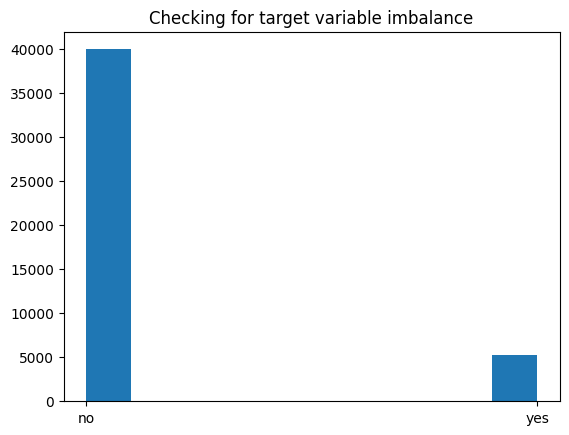

In [27]:
ax = plt.hist(x=df['y'])
plt.title('Checking for target variable imbalance')
plt.show()

**Observation:**

The dataset shows significant class imbalance - far more 'no' responses than 'yes'. This imbalance (approximately 88% negative, 12% positive) means:
- We need to use appropriate evaluation metrics (precision, recall, F1, AUC) rather than just accuracy
- Class weighting will be essential in our models to prevent bias toward the majority class
- The business cost of missing a potential customer (false negative) may be different from incorrectly targeting an uninterested customer (false positive)

## 4. Feature Analysis: Campaign Timing and Demographics

### Approach ###
Looking at dataset's features let us take first steps in understanding of distributions, correlations and patterns. My approach will be:
- Check how the target variable 'y' is distributed throughout the year. I want to check if there's a seasonality in subscriptions
- Check the marital status impact on the outcome of campaign
- Check the impact of the number of contacts
- Take a look at the age distribution
- Investigate for "fatigue" effect: whether there's a refractory period in client's lifecycle

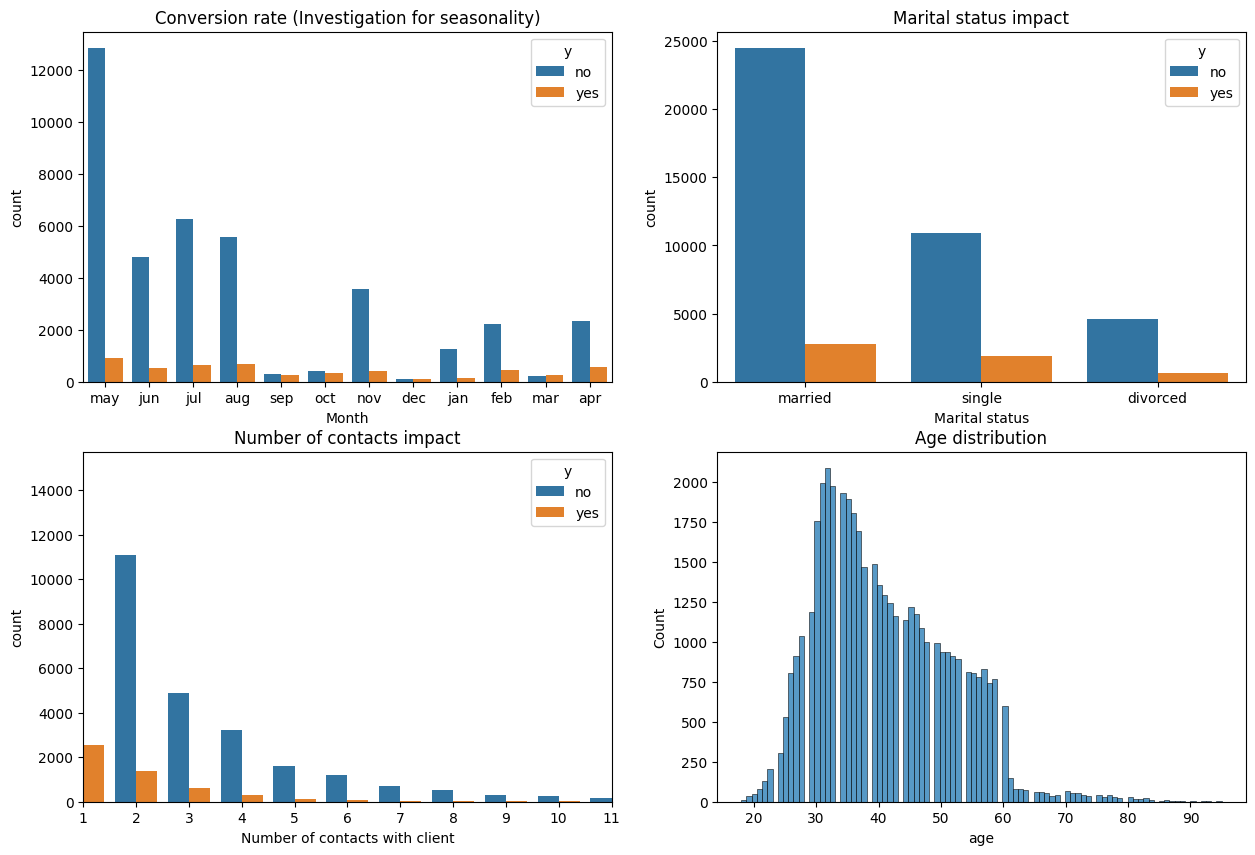

In [31]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
order = ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan',
        'feb', 'mar', 'apr']
ax = sns.countplot(df, x='lc_month', hue='y', ax=axes[0, 0], order=order)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_title('Conversion rate (Investigation for seasonality)')
ax = sns.countplot(df, x='marital', hue='y', ax=axes[0, 1])
axes[0, 1].set_xlabel('Marital status')
axes[0, 1].set_title('Marital status impact')
ax = sns.countplot(df, x='lc_contacts_count', hue='y', ax=axes[1, 0])
axes[1, 0].set_xlim(0, 10)
axes[1, 0].set_xlabel('Number of contacts with client')
axes[1, 0].set_title('Number of contacts impact')
ax = sns.histplot(df, x='age', ax=axes[1, 1])
axes[1, 1].set_xlabel('age')
axes[1, 1].set_title('Age distribution')
plt.show()

In [39]:
encoder = OrdinalEncoder()
df[['y']] = encoder.fit_transform(df[['y']])
df[['marital', 'y']].groupby('marital').agg('mean')

,y
marital,
divorced,0.119455
married,0.101235
single,0.149492


**Observations:**

1. **Seasonality**: May shows the highest campaign activity. March, September, October, and December show better conversion rates (higher proportion of 'yes'). This suggests timing matters (correlates with key ECB rate??).

3.  **Marital Status**: Single customers appear to have slightly higher conversion rates relative to their representation in the dataset.

3. **Contact Frequency**: There's a clear "fatigue effect" - customers contacted only 1-2 times have better conversion rates. Beyond 3-4 contacts, conversion rates drop significantly. This suggests diminishing returns from repeated contacts.
   
4. **Age Distribution**: The age distribution is roughly normal with a peak around 30-40 years. We'll need to investigate if certain age groups convert better.

## 5. Previous Campaign Analysis: Time Since Last Contact

### Analyzing the "Fatigue Effect"
The 'pdays' variable represents days since the customer was last contacted from a previous campaign. Let's analyze if there's an optimal time window for re-contacting customers.

### "Fatigue effect" of previous campaign ###
In order to investigate clients for this effect we need to define conversion rate differently. \
I define new conversion rate as a mean of the target variable of all clients assigned to a certain time period. \
I chose to divide 'pdays' in equally sized bins. The conversion rate will relate to those bins. \
**Encode the target variable for aggregation purposes:** \
Outcome 'no' is now 0 and outcome 'yes' is 1.

C:\Users\zeynk\AppData\Local\Temp\ipykernel_27300\3907858932.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rate = df.groupby('pdays_bin')['y'].mean().reset_index()


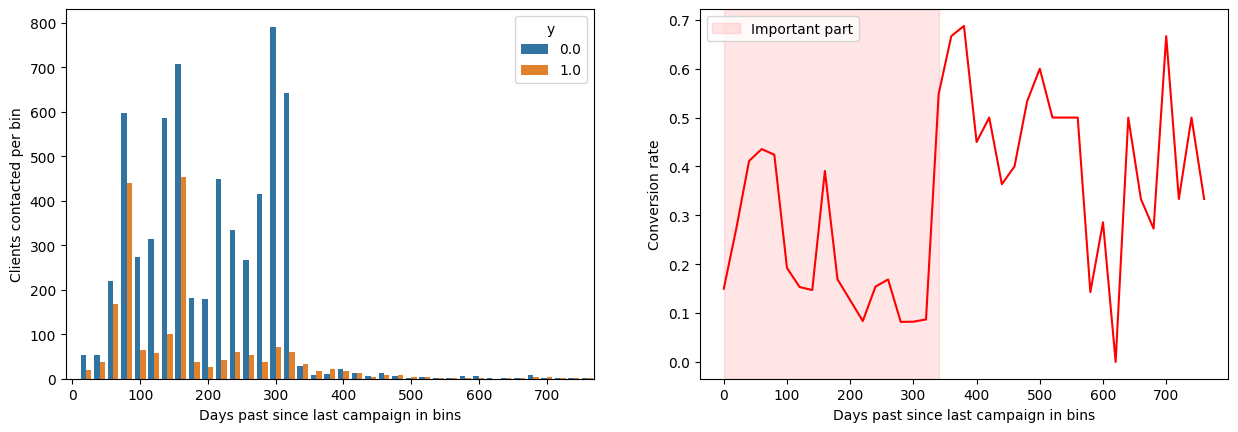

In [48]:
pdays_bins = [i for i in range(0, 800, 20)]
df['pdays_bin'] = pd.cut(df.query('pdays>0')['pdays'], bins=39, labels=np.array(pdays_bins[1:])-20,
                        right=False)
conversion_rate = df.groupby('pdays_bin')['y'].mean().reset_index()

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
ax = sns.countplot(df.query('pdays_bin>0'), x='pdays_bin', hue='y', ax=axes[0])
ticks = axes[0].get_xticks()
axes[0].set_xticks(ticks[::5])
axes[0].set_xlabel('Days past since last campaign in bins')
axes[0].set_ylabel('Clients contacted per bin')
ax = sns.lineplot(conversion_rate, x='pdays_bin', y='y', ax=axes[1],
                  color='red')
axes[1].set_xlabel('Days past since last campaign in bins')
axes[1].set_ylabel('Conversion rate')
axes[1].axvspan(xmin=0, xmax=340, 
                color='red', alpha=0.1, label='Important part')
axes[1].legend()
plt.show()

**Critical Observation:**

This is one of the most important findings:
- Customers contacted within approximately 70-150 days (roughly 3 months) after the previous campaign show much higher conversion rates
- After this window, conversion rates drop dramatically
- Peaks out of the red zone (rates of 60-70%) are no longer representative, since the sample size in those time intervalls is very small
- This suggests a "sweet spot" - customers who were contacted in the mentioned period are significantly more likely to convert
- **Business Implication**: The bank should prioritize re-contacting previous campaign participants within this optimal time window

## 6. Age-balance-outcome density plot ##

Density plots below take some time to visualize target variable distribution along age and balance axes. \
### Please wait... ###

c:\Users\zeynk\Documents\python projects\term deposit campaign\.venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'bin'
  cset = contour_func(
c:\Users\zeynk\Documents\python projects\term deposit campaign\.venv\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'bin'
  cset = contour_func(


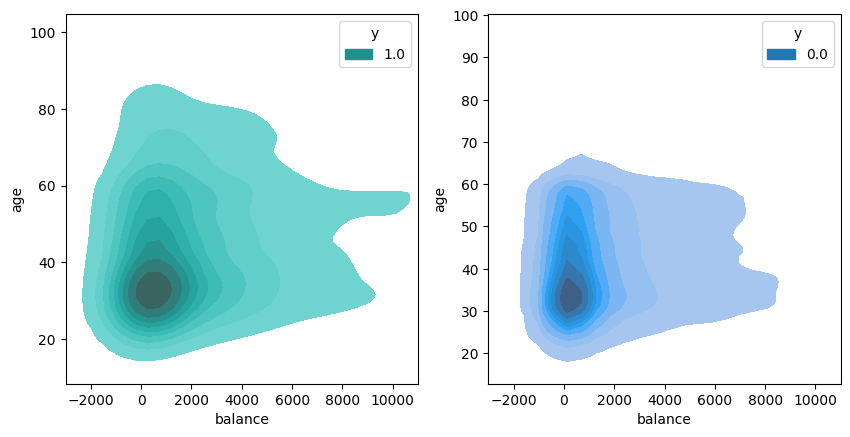

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
ax = sns.kdeplot(data=df[df['y']==1], y='age', x='balance', hue='y', fill=True,
                bin=100, ax=axes[0], palette='viridis')
ax = sns.kdeplot(data=df[df['y']==0], y='age', x='balance', hue='y', fill=True,
                bin=100, ax=axes[1])
axes[0].set_xlim(-3000, 11000)
axes[1].set_xlim(-3000, 11000)
plt.show()

**Observations:**
- Converters (y=1) show concentration in middle age groups (30-50) with moderate to high balances
- The density plot shows that customers with positive balances and in the middle age range are more likely to convert
- Both negative and very high balances are less common among converters, suggesting moderate financial stability correlates with subscription

## 7. Loan Distributions ##
Let's look at 'loan' and 'housing' distributions.

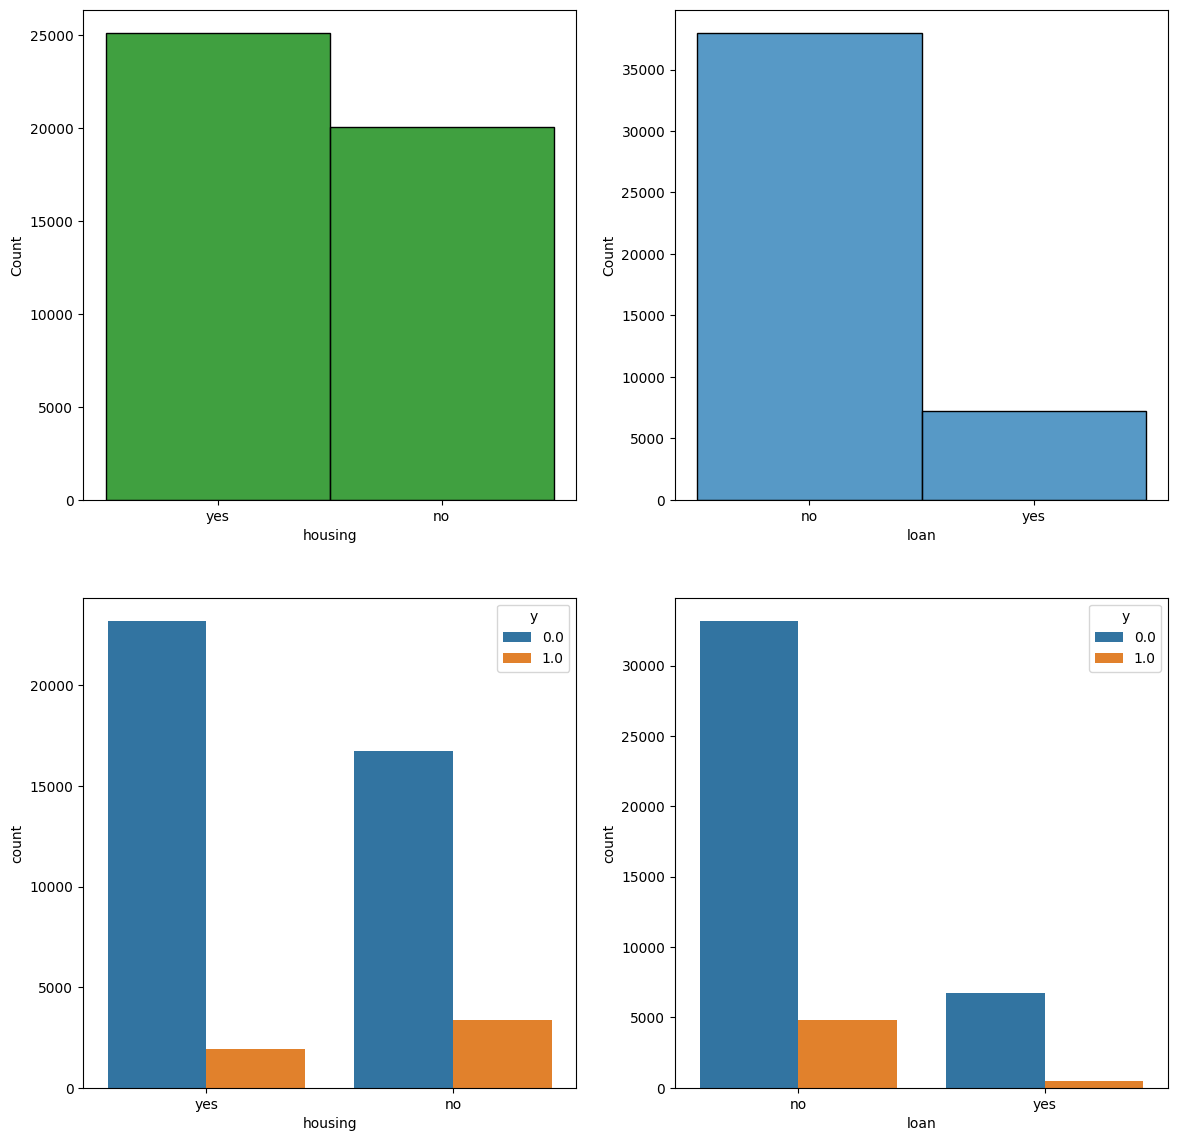

In [20]:
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(14)
ax = sns.histplot(data=df, x='housing', ax=axes[0, 0], color='green')
ax = sns.histplot(data=df, x='loan', ax=axes[0, 1])
ax = sns.countplot(data=df, x='housing', hue='y', ax=axes[1, 0])
ax = sns.countplot(data=df, x='loan', hue='y', ax=axes[1, 1])
plt.show()

**Observations:**
- Most customers have housing loans but not personal loans
- Customers WITHOUT loans (both housing and personal) show slightly higher conversion rates
- This makes intuitive sense: customers without loan obligations may have more disposable income for term deposit investments

## 8. Job, Education and Balance analysis

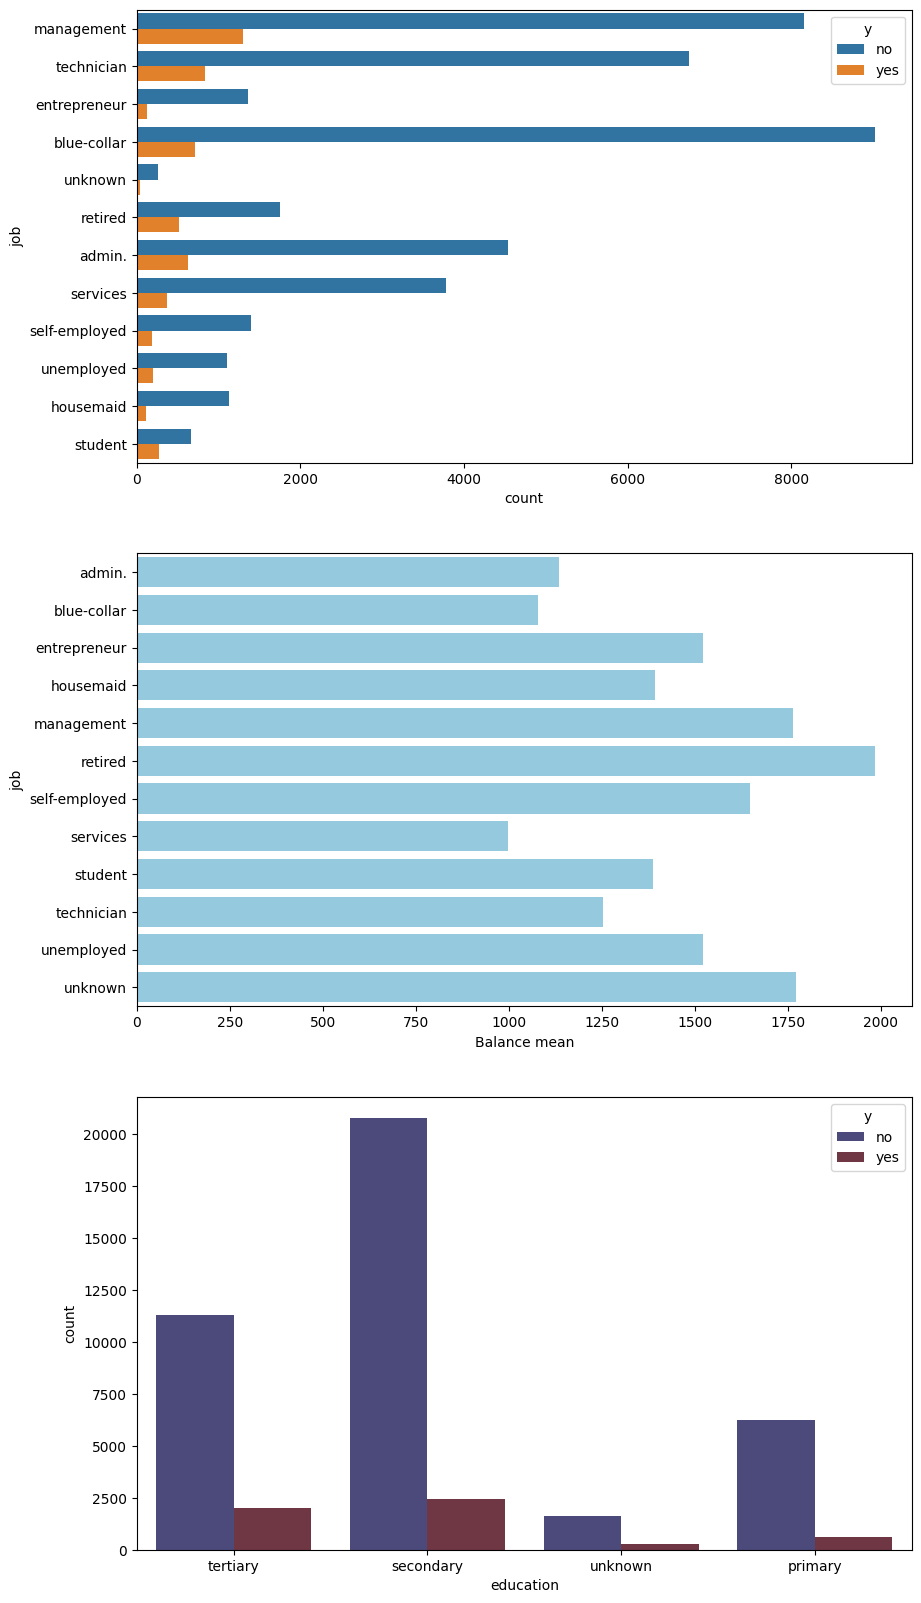

In [29]:
fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(20)
ax = sns.countplot(data=df, y='job', hue='y', ax=axes[0])
balance_means = df.groupby('job')['balance'].agg(
    mean_balance='mean',
    count='count').reset_index()
ax = sns.barplot(data=balance_means, x='mean_balance', y='job', ax=axes[1],
                 color='skyblue')
axes[1].set_xlabel('Balance mean')
ax = sns.countplot(df, x='education', hue='y', ax=axes[2], palette='icefire')

In [44]:
df[['job', 'y']].groupby('job').agg('mean')

,y
job,
admin.,0.122027
blue-collar,0.072750
entrepreneur,0.082717
housemaid,0.087903
management,0.137556
retired,0.227915
self-employed,0.118429
services,0.088830
student,0.286780


In [45]:
df[['education', 'y']].groupby('education').agg('mean')

,y
education,
primary,0.086265
secondary,0.105594
tertiary,0.150064
unknown,0.135703


**Observations:**

1. **Job Type**: 
   - Retired customers and students show higher conversion rates
   - Management and white-collar jobs also convert well
   - Blue-collar workers show lower conversion rates
   
2. **Balance by Job**: 
   - Retired customers have the highest average balances
   - This correlates with their higher conversion rates
   
3. **Education**: 
   - The higher the education level, the higher the conversion rate
   - Unknown education level has surprisingly high conversion
   - This suggests education level is a meaningful predictor

## 9. Call Duration Analysis - A Critical Variable

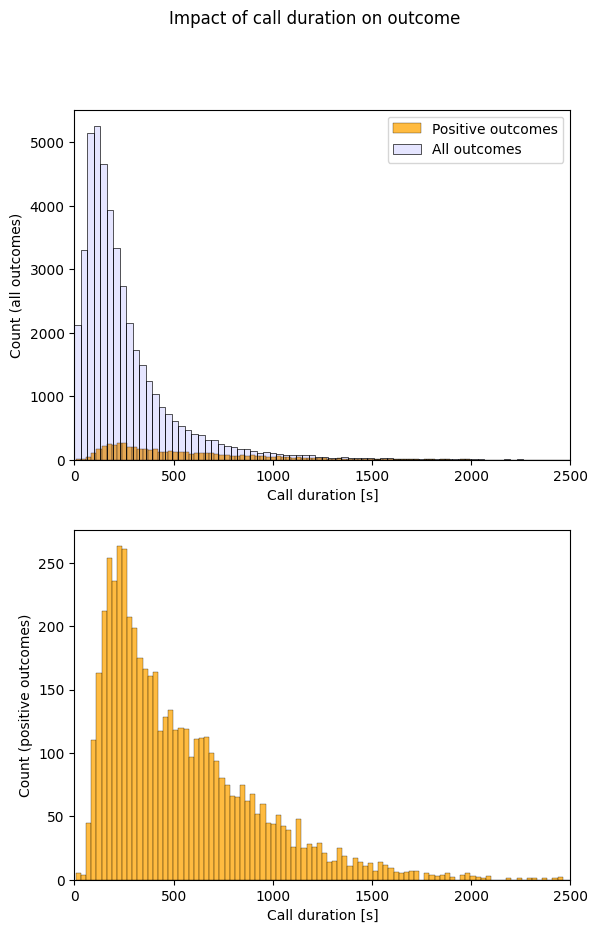

In [46]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
ax = sns.histplot(df[df['y']==1], x='lc_duration', bins=150, color='orange', ax=axes[1])
ax.set_xlim(0, 2500)
axes[0].set_xlabel('Call duration [s]')
axes[1].set_xlabel('Call duration [s]')
axes[0].set_ylabel('Count (all outcomes)')
axes[1].set_ylabel('Count (positive outcomes)')
ax = sns.histplot(df[df['y']==1], x='lc_duration', bins=150, color='orange', ax=axes[0],
                  legend=True, label='Positive outcomes')
ax.set_xlim(0, 2500)
sns.histplot(df, x='lc_duration', bins=150, color='blue', ax=axes[0], 
            alpha=0.1, legend=True, label='All outcomes')
axes[0].legend()
fig.suptitle('Impact of call duration on outcome')
plt.show()

**Critical Observation - Data Leakage Issue:**

Call duration shows a very strong correlation with positive outcomes (according to dataset description. We will take a closer look at correlation matrix later). However, this creates a problem:
- In practice, we don't know call duration before making the call
- Duration is measured during/after the call, but the outcome is determined by the conversation
- Longer calls might result from customer interest (leading to conversion), not cause it
- Including this feature would create **data leakage** in a production model

**Decision**: I will exclude 'lc_duration' from the final model to create a realistic predictor that can be used before contacting customers. This is an important consideration for real-world deployment where we need to predict outcomes before the interaction occurs.

## 10. Feature Engineering

### Creating Derived Features
Based on our EDA, I'll create a conversion rate feature from the 'pdays' analysis.

In [50]:
df['pdays_bin'] = df['pdays_bin'].fillna(0)
df['conversion_rate'] = df.query('pdays>0').groupby('pdays_bin')['y'].mean()
df['conversion_rate'] = df['conversion_rate'].fillna(df['conversion_rate'].mean())
df['conversion_rate'].head()

C:\Users\zeynk\AppData\Local\Temp\ipykernel_27300\2943727241.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['conversion_rate'] = df.query('pdays>0').groupby('pdays_bin')['y'].mean()


0    0.149701
1    0.337121
2    0.337121
3    0.337121
4    0.337121
Name: conversion_rate, dtype: float64

In [52]:
categorical = ['job', 'marital', 'education', 'default', 'housing',
               'loan', 'lc_month', 'lc_contact_type', 'poutcome', 'pdays_bin']
df[categorical] = encoder.fit_transform(df[categorical])
df[categorical].head()

,job,marital,education,default,housing,loan,lc_month,lc_contact_type,poutcome,pdays_bin
0,4.0,1.0,2.0,0.0,1.0,0.0,8.0,2.0,3.0,0.0
1,9.0,2.0,1.0,0.0,1.0,0.0,8.0,2.0,3.0,0.0
2,2.0,1.0,1.0,0.0,1.0,1.0,8.0,2.0,3.0,0.0
3,1.0,1.0,3.0,0.0,1.0,0.0,8.0,2.0,3.0,0.0
4,11.0,2.0,3.0,0.0,0.0,0.0,8.0,2.0,3.0,0.0


### Transformation of 'balance' ###
* It is a common practice to transform incomes and balances to smoothen the distribution. In our case balances can be negative, so I will choose Yeo-Johnson transformer instead of log

In [54]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df['balance_tf'] = pt.fit_transform(df[['balance']])
df['balance_tf'].head()

0    0.414773
1   -0.410774
2   -0.431122
3    0.197685
4   -0.432119
Name: balance_tf, dtype: float64

## 11. Correlation Analysis

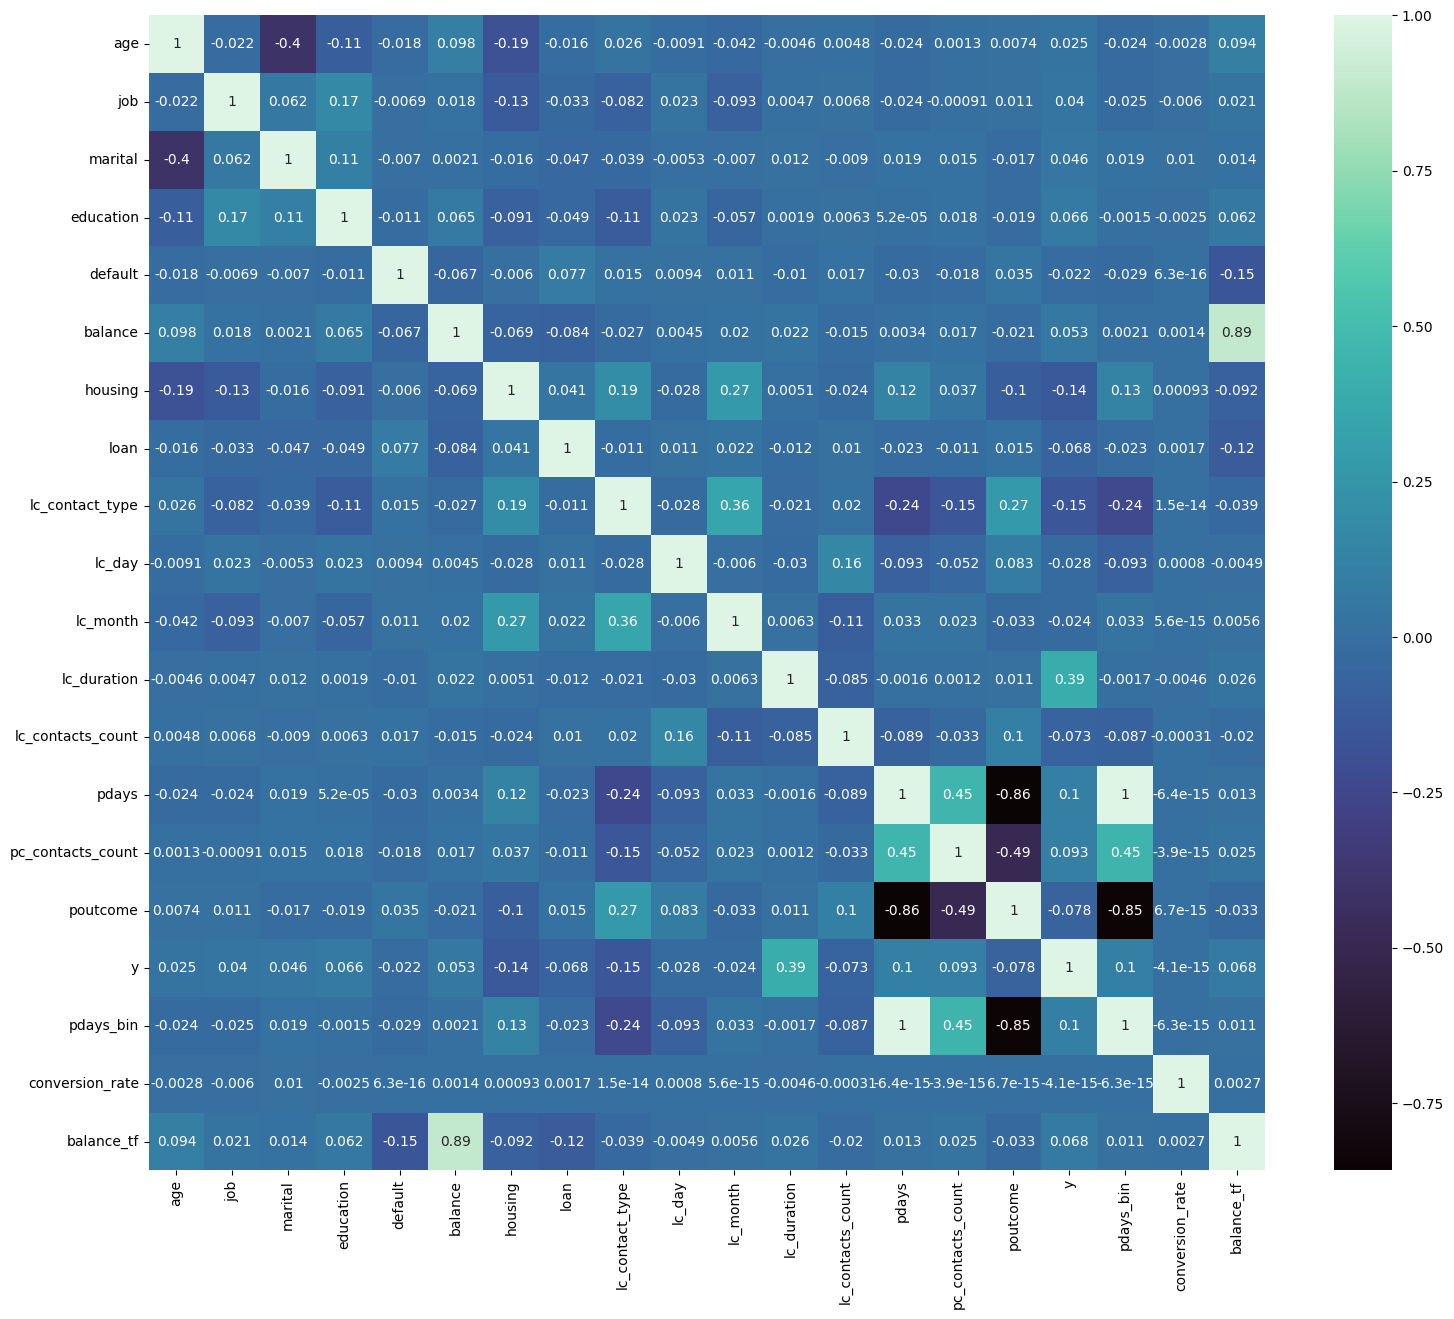

In [55]:
corr_matrix = df.corr()
fig = plt.figure()
ax = sns.heatmap(corr_matrix, cmap='mako', annot=True)
fig.set_figheight(15)
fig.set_figwidth(18)

**Observations from Correlation Matrix:**
- 'pdays' and related features show moderate correlation with target
- As expected, 'lc_duration' shows very high correlation with target (but we're excluding it)
- Most features show low multicollinearity, which is good for model performance

## 12. Model Development

### Defining Evaluation Metrics

**Business Context for Metric Selection:**

In this marketing campaign context, missing a potential customer (False Negative) is likely more costly than contacting an uninterested customer (False Positive) because:
- Acquiring new customers is expensive
- Lost opportunities are harder to recover
- Contact costs are relatively low compared to customer lifetime value

Therefore, I'll focus on:
- **Recall**: To minimize missing potential customers
- **AUC-ROC**: For overall model discriminative ability
- **F1-Score**: For balanced performance
- **Precision**: To avoid excessive false positives

## 13. Baseline Model: Logistic Regression

Starting with Logistic Regression as a baseline model for interpretability and simplicity.

In [56]:
from sklearn.model_selection import train_test_split
X = df.drop(['y', 'balance', 'lc_duration'], axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y,
                                                    shuffle=True, random_state=42)

In [58]:
pd.DataFrame(y_train).value_counts()

y  
0.0    31937
1.0     4231
Name: count, dtype: int64

In [57]:
pd.DataFrame(y_test).value_counts()

y  
0.0    7985
1.0    1058
Name: count, dtype: int64

In [59]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

*Calculate weight for the least class in train set*

In [60]:
w = (y_train[y_train['y']==0].count(axis=0).sum() / y_train[y_train['y']==1].count(axis=0).sum())

*Create a baseline model*

In [62]:
log_regressor = LogisticRegression(class_weight={0:1, 1:w},
                                   max_iter=10000)

### Now we can train our model and test it's performance on validation set

In [63]:
log_regressor.fit(X_train, y_train)
y_proba = log_regressor.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

AUC = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}; recall: {recall:.4f}; AUC: {AUC:.4f}; f1: {f1:.4f}')

c:\Users\zeynk\Documents\python projects\term deposit campaign\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.2095; recall: 0.7098; AUC: 0.7338; f1: 0.3236


## 14. Advanced Models: XGBoost and AdaBoost

### XGBoost Model
XGBoost is a powerful gradient boosting algorithm that often performs well on structured data (usually works best right out of the box).

### AdaBoost Model
AdaBoost with Decision Tree as base estimator for comparison.

***Models are already tuned by me empirically***

In [64]:
tree_model = DecisionTreeClassifier(max_depth=7, random_state=42, 
                                    class_weight={0:1, 1:w}, max_features=3)
xg_model = XGBClassifier(max_depth=3, n_estimators=100, scale_pos_weight=w,
                         random_state=42, learning_rate=0.2, eval_metric='auc')
ada_model = AdaBoostClassifier(estimator=tree_model, n_estimators=100, learning_rate=0.2,
                               random_state=42)

In [65]:
xg_model.fit(X_train, y_train)
y_proba_xg = xg_model.predict_proba(X=X_test)[:, 1]
y_pred_xg = (y_proba_xg >= 0.48).astype(int)
# %%
AUC_xg = roc_auc_score(y_test, y_proba_xg)
f1_xg = f1_score(y_test, y_pred_xg)
precision_xg = precision_score(y_test, y_pred_xg)
recall_xg = recall_score(y_test, y_pred_xg)
print(f'XGBOOST. Precision: {precision_xg:.4f}; recall: {recall_xg:.4f}; AUC: {AUC_xg:.4f}; f1: {f1_xg:.4f}')

XGBOOST. Precision: 0.3111; recall: 0.6796; AUC: 0.8035; f1: 0.4268


In [66]:
ada_model.fit(X_train, y_train)
y_proba_ada = ada_model.predict_proba(X_test)[:, 1]
y_pred_ada = (y_proba_ada >= 0.48).astype(int)
# %%
AUC_ada = roc_auc_score(y_test, y_proba_ada)
f1_ada = f1_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
print(f'AdaBoost. Precision: {precision_ada:.4f}; recall: {recall_ada:.4f}; AUC: {AUC_ada:.4f}; f1: {f1_ada:.4f}')

AdaBoost. Precision: 0.3621; recall: 0.5189; AUC: 0.7569; f1: 0.4266


c:\Users\zeynk\Documents\python projects\term deposit campaign\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model selection
**From the raw performance tests we can see, that tuned xgboost model shows the best AUC-score.** \
**The decision threshold can be adjusted to reach the desired recall, while not losing too much of precision.**

## 15. Cross-Validation for Robust Evaluation

### 5-Fold Stratified Cross-Validation
To ensure our model performance is stable and not dependent on a single train-test split, I'll perform stratified k-fold cross-validation.

In [68]:
def cv(model, threshold, X, y):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    auc_scores = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        y_test, X_test

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba>=threshold).astype(int)

        auc_scores.append(roc_auc_score(y_test, y_proba))
        f1s.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))

    print(f'Performance of {model} \n')
    print(f'AUC: {np.mean(auc_scores):.4f}; f1: {np.mean(f1s):.4f}; precision: {np.mean(precisions):.4f}; recall: {np.mean(recalls):.4f}')

In [69]:
cv(xg_model, 0.4, X, y)
cv(ada_model, 0.4, X, y)

Performance of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...) 

AUC: 0.7965; f1: 0.3583; precision: 0.2347; recall: 0.7574
Performance of AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                  1: np.float64(

## 16. Conclusions and Business Recommendations

### Key Findings:

**1. Model Performance:**
- XGBoost achieved the best overall performance with AUC-ROC around 0.80
- The model shows strong ability to discriminate between customers who will and won't subscribe
- Cross-validation confirms the model's stability across different data splits
- Recall was prioritized to minimize missing potential customers

**2. Most Important Features (from EDA):**
- **Days since last contact (pdays)**: Critical time window of 70-150 days shows 50% conversion
- **Contact frequency**: 1-2 contacts optimal; diminishing returns after that
- **Seasonality**: March, September, October, December show better conversion
- **Demographics**: Retired customers, students, and those with tertiary education convert better
- **Financial profile**: Moderate balance and no outstanding loans correlate with conversion

**3. Critical Insight - Data Leakage:**
- Call duration was excluded from the model due to data leakage. It also shows high correlation with target variable
- Usually we want to exclude outstanding predictors with high correlation with target variable, so that model won't "cheat"
- This ensures the model can be used before contacting customers (real-world deployment)

### Business Recommendations:

**1. Customer Prioritization Strategy:**
   - **High Priority**: Customers previously contacted 70-150 days ago with positive outcomes
   - **Target Months**: Focus campaigns in March, September, October, December
   
**2. Campaign Optimization:**
   - Limit contacts to 1-2 attempts per customer to avoid fatigue
   - Use the model to score customers before calling
   - Focus resources on high-probability customers identified by the model

---

### Answers to Assignment Questions:

**Q: Would you consider additional data points for prediction?**

**A:** Yes, valuable additions would include:
- **Customer transaction history**: Frequency, types of transactions, account activity patterns
- **Digital banking engagement**: Mobile app usage, online banking frequency
- **Previous product subscriptions**: History with other bank products and their performance
- **Customer satisfaction scores**: From previous interactions or surveys

These additional features would help create a more comprehensive customer profile and potentially improve prediction accuracy.

---

**Q: Can the findings be applied to other bank departments?**

**A:** Absolutely! The methodology and insights can be adapted for:
- **Loan Products**: Similar predictive modeling for personal/housing loan uptake
- **Credit Cards**: Predicting credit card application success and usage patterns (I already made end-to-end project on this topic)
- **Insurance Products**: Identifying customers likely to purchase insurance (especially relevant for european countries with high trust in insurance products)
- **Investment Products**: Targeting customers for mutual funds (or their analogs if in Germany) or wealth management services

---

**Q: How should the problem formulation be adjusted for other departments?**

**A:** Key adjustments needed:

**1. Feature Engineering - Product-Specific Behaviors:**
   - **For Loans**: Focus on debt-to-income ratios, employment stability, credit history, existing debt obligations
   - **For Credit Cards**: Spending patterns, existing credit utilization, payment history
   - **For Insurance**: Age, health indicators (if available), family status, risk profile

**2. Target Definition - Different Success Metrics:**
   - **Loans**: Not just application, but also an approval
   - **Credit Cards**: Activation rate and subsequent usage patterns

**3. Cost-Benefit Analysis - Adjust Model Thresholds:**
   - **Loans and Credit Cards**: High recall is still prioritized (if we consider 'default' as target value and 'yes' as bad scenario) due to credit risk; false negatives are costlier

---

**Analysis Complete!**